## Introduction

In this notebook I will face a classification task: from a collection of audio tracks, whose speakers are male or female, I will have to build different architectures in order to understand which one fit better the problem of gender recognition.

#### Requirements

* pandas
* numpy
* librosa
* sklearn
* keras

* You need to download the dev-clean corpus LibriSpeech [here](http://www.openslr.org/12/) and save it in this folder.

#### First steps
* The first step will be matching the gender of the speaker with the corresponding audio file. The audio tracks are stored in `LibriSpeech/dev-clean/speaker_id/chapter_id/audio_file.flac`. While finding all the audio tracks, we can easily associate them with their speaker id. Then we will have to find the gender for every speaker: this information is stored in `LibriSpeech_dev/SPEAKERS.TXT`.

#### Features extraction and preprocessing
* The second step will be extracting the MFCC features from every track (more details in the corresponding section). Then we will have to fix the size of the audio tracks: we need to have the same fixed size for every track -- this will be a case of study later in the notebook.

#### Machine Learning algorithms
* I will start with some baseline methods, Naive Bayes Classifier, Logistic Regression, simple SVM and Random Forest, before going more in depth.
* I decided that it would be interesting to see the behaviours of three different models: feed forward network, convolutional network and recurrent network. For each of them I will build two architectures, a simple one and one deeper (with more hidden layers).
* The last step will be comparing these architectures and understanding why some of them perform better than otners

In [1]:
import glob
import os
import pandas as pd
from functools import reduce

## Extracting speakers and chapters

* The files are stored with this structure: `LibriSpeech/dev-clean/speaker_id/chapter_id/audio_file.flac`. Using the os separator, I am going to obtain speaker_id, chapter_id and complete filepath separating the string and taking the second (speaker) and third (chapter) last elements.

In [2]:
# Temporary dataframe where I store partial info
df_temp = pd.DataFrame()
# List with all the filepaths
all_files = glob.glob(os.path.join('LibriSpeech/dev-clean/', '*/*/*.flac'), recursive=True)
# Storing info
df_temp['speaker_id'] = [int(p.split(os.path.sep)[-3]) for p in all_files]
df_temp['chapter_id'] = [int(p.split(os.path.sep)[-2]) for p in all_files]
df_temp['file_path'] = [p for p in all_files]
df_temp.head()

,speaker_id,chapter_id,file_path
0,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...
1,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...
2,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...
3,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...
4,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...


* For our classification task we need the gender labels. We can find them in the file `LibriSpeech_dev/SPEAKERS.TXT`. I am extracting speaker and sex and eventually merging the previous dataframe with the following

In [3]:
# Extracting speakers tuples -- (id, sex, total minutes of speech).
# This df will contain the labels (sex)
speakers = pd.read_table('LibriSpeech/SPEAKERS.TXT', comment=';', header=None)
speakers = speakers.loc[:, 0].str.split('|', expand=True).rename(columns={0:'speaker_id',1:'sex',2:'subset',3:'minutes',4:'name'}).loc[:,['speaker_id', 'sex', 'minutes']]
speakers.speaker_id = speakers['speaker_id'].apply(pd.to_numeric)
speakers = speakers.set_index('speaker_id').loc[df_temp.speaker_id.unique()].reset_index()
# Fixing some wrong parsing
speakers.sex = speakers.sex.str.strip()
speakers.minutes = speakers.minutes.apply(pd.to_numeric)
speakers.head()

,speaker_id,sex,minutes
0,2412,F,8.06
1,2078,M,8.03
2,3752,M,8.06
3,1988,F,8.16
4,1919,F,8.17


* Another information at our disposal is the number of minutes of speech for every speaker. This is an useful information because we can compute the total duration of male and female speech and see if there imbalance between the two.

In [4]:
speakers[speakers.sex=='F'].minutes.sum(), speakers[speakers.sex=='M'].minutes.sum()

(161.44999999999999, 161.83000000000001)

* We can see that there no imbalance between the two classes.
* Now I will merge the two datasets on the speaker_id, in order to have the complete final one with speaker_id, chapter_id, file_path and gender

In [5]:
# Finally merging and keeping only what we need
dataset = df_temp.merge(speakers, on='speaker_id', how='inner').drop('minutes', axis=1)
dataset.head()

,speaker_id,chapter_id,file_path,sex
0,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
1,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
2,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
3,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
4,2412,153954,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F


## Features extraction

* I am going to extract the MFCC (Mel Frequency Cepstral Coefficients) features from the audio tracks. Since an audio signal is constantly changing, when extracting these features we are assuming that on short time scales the audio signal does not change much. That's why, when extracting the features, we frame the audio signal in short frames.
* Second step is to calculate for each frame the periodogram estimate of the power spectrum.
* Since the periodogram estimate is not enough to understand all the information, such as how much energy exists in various frequency regions, a Mel filterbank is used.
* Then we take the logarithm of the filterbank energies: this step is "intuitive" since we don't hear in a linear scale.
* Last step is to take the DCT (Discrete Cosine Transform) of the log filterbank energies: the DCT decorrelate the filterbanks energies that are correlated between each other since the filterbank are overlapping. We are going to keep the first 20 coefficients of the DCT as features. [1]

*[1] [http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/]*


##### Librosa library
* For loading the audio tracks and extracting the MFCC features I am using the `librosa` library. I am using a sampling rate of 22.050 kHz (default one) to sample the audio tracks (one sample every 0,05ms). Using this sampling rate, when extracting the features, the librosa library calculate them every ~500 samples, that means every 25ms.

In [60]:
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
SAMPLING_RATE = 22050

In [7]:
# Utility functions
def compute_mfcc(filepath):
    """
    :param filepath: path to the audio file
    :return: mfcc coefficients with time series as rows and features as columns
    """
    audio, sampling_rate = librosa.load(filepath, sr=SAMPLING_RATE, mono=True)
    # computing coefficients
    coefficients = librosa.feature.mfcc(y=audio,sr=SAMPLING_RATE)
    
    return coefficients.T

def subsample_data(data, threshold):
    """
    :param data: list composed of element of different sizes
    :param threshold: threshold used to split the data
    :return: list of elements of same size taken as fixed size chunks from data elements
    """
    data_subsampled = []
    for sample, target in data:
        chunks = [sample[i:threshold+i] for i in range(0, len(sample)-threshold, threshold)]
        
        for el in chunks:
            data_subsampled.append((el, target))
    
    return np.array(data_subsampled)

def get_gender_data(data, gender):
    """
    Return a flattened list of all the data corresponding to the selected gender
    """
    return np.array([el for sublist, target in data for el in sublist if target == gender])

def compute_duration(data):
    """
    Compute the total duration of the data, supposing that the data as the structure (input, target)
    """
    return np.sum(list(map(lambda x: len(x), data[:,0])))
    
def print_info_subsamples(data_sub, threshold):
    print('Threshold: ', threshold)
    print('Number of subsamples: ', len(data_sub))
    print('Sample shape: ', data_sub[:,0][0].shape)
    print('Total length: ', compute_duration(data_sub))

#### Example for one audio track

In [61]:
# First audio file
f = dataset.loc[1].file_path

# Decode the flac and load the audio in memory
audio, sampling_rate = librosa.load(f)
coefficients = compute_mfcc(f)
print(len(audio))
print('MFCC coefficients shape: {}'.format(coefficients.shape))

# Load the audio in the browser and play it.
ipd.Audio(data=audio, rate=sampling_rate)

58433
MFCC coefficients shape: (115, 20)


* In order to have a complete idea of what we are talking about, I will display the audio signal and the MFCC spectrum across the audio signal

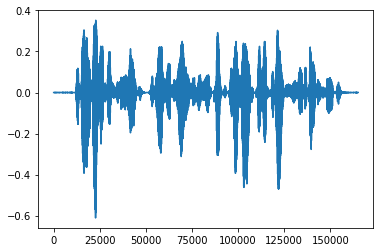

In [40]:
# Showing the audio track sample
plt.plot(audio)
plt.show()

#### MFCC extraction from every audio track

* Here I store all the input and targets -- as tuples -- in the data list. 

*NB*: 0 category refer to females, 1 to males

In [8]:
# data list will contains tuples (input_data, target)
data = []
# Iterating on the dataset
for i, x in dataset.iterrows():
    sex = 0 if x.sex == 'F' else 1
    # Computing the mfcc coefficients for the audio file
    coefficients = compute_mfcc(x.file_path)
    # Appending to data the tuple containing the matrix timeseries-mfcc_features and sex
    data.append((coefficients, sex))

In [9]:
data = np.array(data)
len(data)

2703

#### Fixing size of the data
The features extraction from the audio signal involve the framing of every track in short framings: for the default sampling_rate (22050) of `librosa` library, when we extract the features the audio track is divided in intervals of (~) 500 elements, as you can see in the example for one audio track.
Our input data must have a fixed size in order to use machine learning algorithms (fixed number of weights). For this reason we have to find a way to fix these inputs. Here are three ideas:
* Padding: we can take the longest audio track and pad all the other tracks with zeros;
* Padding and truncating: we can look at the average length (duration) of the tracks and truncate the ones that are longer and pad the ones that are shorter;
* Dividing the tracks in smaller tracks of a fixed size.

In my opinion the third choice is the best one: in this way we are not going to lose too much data and we are not adding anything that was not contained in the tracks.
First I'll try to use the shortest one as fixed size, but this could lead to a bad accuracy: it can happen that the audio tracks are too short for the models to understand the speaker's gender.<br/> In this case I'll just increase the minimum size, discard the ones that are shorter and subsamples the other ones with a bigger sample size.

It will be interesting to see which of the following would perform better:
* Taking the first `sample_length//size` and discard the rest (ex: `audio_sample_length = 9`, `min_size = 2`. Taking the first 4 intervals and discarding the last 1 (of length 1);
* Taking random `sample_length//size` subsamples from the audio track, with the consciousness that random generally performs well, even if in this case we could risk some overlapping.

For the moment I will procede with a cronological sampling (first idea). If it will not perform well, I will try the random one.

#### Info about the data size
* Here I show some info about the data: I am particularly interested in how many frames every input is composed of. The reason behind this is that I am going to subsample and I want to have a clear idea of the loss of the data and to get the right subsampling interval.

In [63]:
# Storing the number of intervals for every input data 
num_samples_list = sorted(map(lambda x: len(x), data[:,0]))
print('Min: ', min(num_samples_list))
print('Max: ', max(num_samples_list))
print('Mean: ', np.mean(num_samples_list))
print('25%: ', np.percentile(num_samples_list, 25))
print('50%: ', np.percentile(num_samples_list, 50))
print('75%: ', np.percentile(num_samples_list, 75))
print('Total length: ', np.sum(num_samples_list))
print('Number of samples: ', len(num_samples_list))

Min:  63
Max:  1406
Mean:  309.536440991
25%:  162.0
50%:  255.0
75%:  400.0
Total length:  836677
Number of samples:  2703


* I have printed the total length (the total number of frames) to understand the future data loss when I will subsample.<br/>
    The minimum value is 63, so this will be the first minimum threshold, that can be changed if the perfomances are not good enough.

In [64]:
threshold = 63
data_sub = subsample_data(data, threshold)
print_info_subsamples(data_sub, threshold)

Threshold:  63
Number of subsamples:  11895
Sample shape:  (63, 20)
Total length:  749385


We can see that we have lost almost the 10% of the data fixing the size. Let's see if the data is still balanced or not.

In [65]:
len(get_gender_data(data_sub, 0)), len(get_gender_data(data_sub, 1))

(373086, 376299)

#### Looking at the features distribution over all samples

* In this section I am going to do a general analysis of the features, looking at their distribution in the two cases: gender = male and gender = female. I decided to divide the plots in two columns (female, male) because I wanted to see if there are some differences between the two categories.

In [67]:
# Plotting functions
def plot_distribution(axes, row, column, feature, title):
    """
    Plot the distribution of a feature in a histogram for a specific gender
    """
    ax = axes[row, column] if len(axes.shape) > 1 else axes[column]
    ax.hist(feature)
    ax.set_title(title)
    ax.set_xlabel('value')
    
def plot_box(axes, row, column, feature, title):
    """
    Plot the distribution of a feature in a boxplot for a specific gender
    """
    ax_box = axes[row, column] if len(axes.shape) > 1 else axes[column]
    ax_box.boxplot(feature)
    ax_box.set_title(title)
    ax_box.set_xlabel('value')
    
def plot_stats(axes, row, column, feature, title, kind='hist'):
    """
    Depending on argument 'kind', the function calls plot_distribution or plot_box
    """
    if kind == 'hist':
        plot_distribution(axes, row, column, feature, title)
    else:
        plot_box(axes, row, column, feature, title)
    plt.tight_layout()
        
def plot_thresh(stats, x_label, y_labels, ticks, title):
    """
    Given a list of dict containing score and duration for different thresholds, the function
    plots a bar plot and scatter plot showing the accuracy and the total duration of the audio samples
    with respect to the threshold.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    n_ticks = len(stats['score'])
    ax_bar = axes[0]
    ax_scatter = axes[1]
    
    acc = y_labels[0]
    ax_bar.bar(np.arange(n_ticks), stats['score'])
    ax_bar.set_xticks(np.arange(n_ticks))
    ax_bar.set_xticklabels(ticks)
    ax_bar.set_title(acc + ' ' + title)
    ax_bar.set_ylabel(acc)
    ax_bar.set_xlabel(x_label)
    
    n_s = y_labels[1]
    ax_scatter.scatter(np.arange(n_ticks), stats['duration'])
    ax_scatter.set_xticks(np.arange(n_ticks))
    ax_scatter.set_xticklabels(ticks)
    ax_scatter.set_title('duration ' + title)
    ax_scatter.set_title(n_s + ' ' + title)
    ax_scatter.set_ylabel(n_s)
    ax_scatter.set_xlabel(x_label)

In [67]:
# Taking all the samples as a long time series for each category
male_samples = get_gender_data(data, 1)
female_samples = get_gender_data(data, 0)

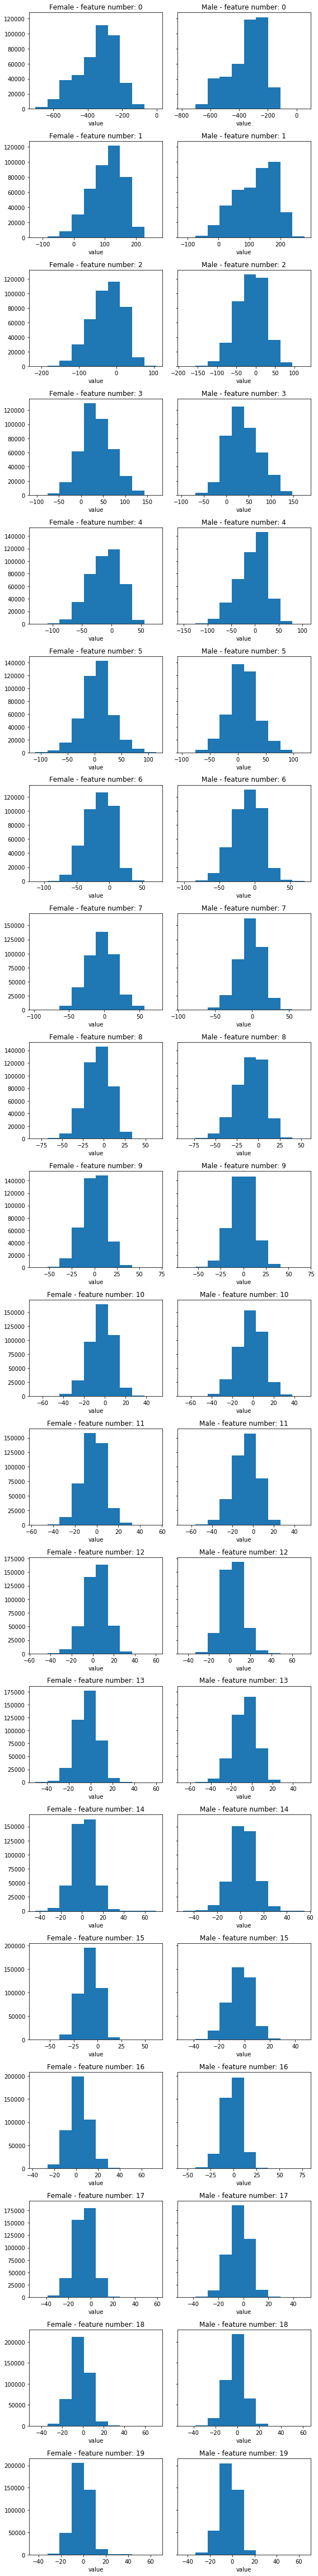

In [68]:
num_features = len(male_samples[0])
fig, axes = plt.subplots(20, 2, figsize=(8,64), sharey='row')

for i in range(num_features):
    plot_stats(axes, i, 0, female_samples[:,i], 'Female - feature number: {}'.format(str(i)), kind='hist')
    plot_stats(axes, i, 1, male_samples[:,i], 'Male - feature number: {}'.format(str(i)), kind='hist')

plt.show()

* From the histograms we can see that the features seem normally distributed, some more skewed than others, but with no big differences between the two genders. <br\> In order to obtain some additional information, I am going to plot the boxplots of the features' distributions here below.

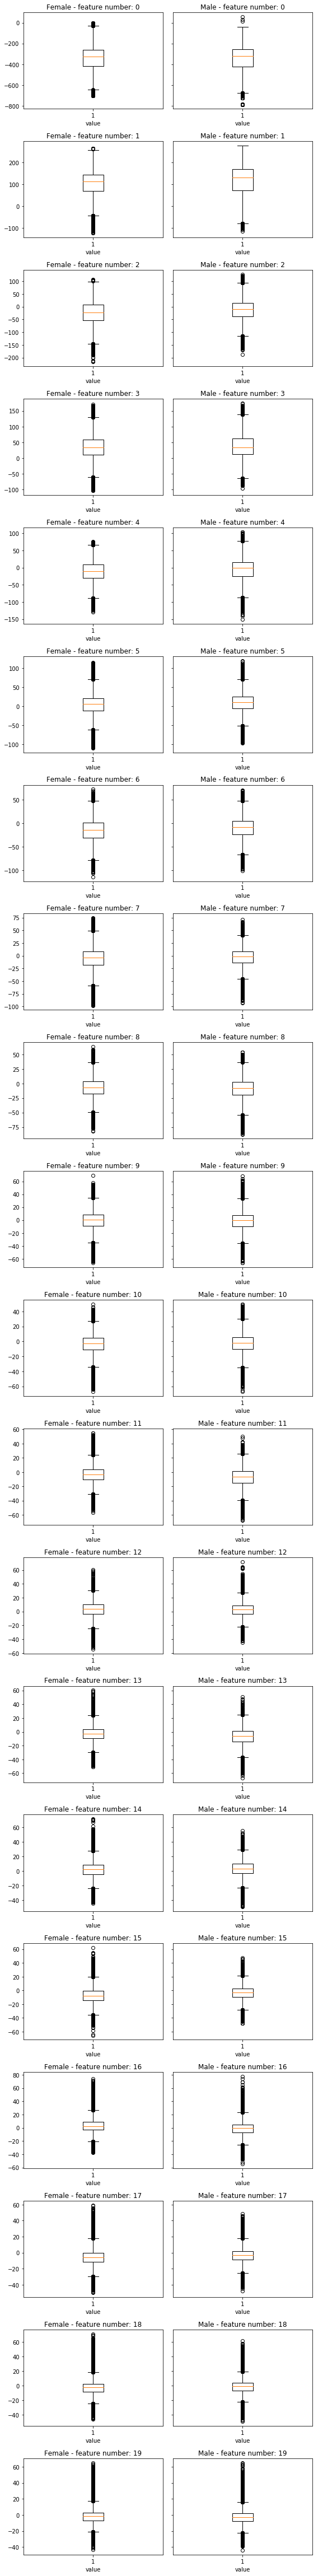

In [69]:
num_features = len(male_samples[0])
fig, axes = plt.subplots(20, 2, figsize=(8,64), sharey='row')

for i in range(num_features):
    plot_stats(axes, i, 0, female_samples[:,i], 'Female - feature number: {}'.format(str(i)), kind='box')
    plot_stats(axes, i, 1, male_samples[:,i], 'Male - feature number: {}'.format(str(i)), kind='box')

plt.show()

* From the boxplots we have another confirmation that the features have a very similar distribution for the two classes. Most of them are centered in the zero. The boxplots show us the presence of "outliers", but I am not going to consider them: for some features there a lot of them and it does not make sense to delete them or treat them differently. If there will not be problems in the classification task it will mean that these were not "real" outliers.

## Machine Learning

* The main idea of this section is to start from some basics machine learning algorithms and arrive to deep neural networks in order to observe the evolution of loss/accuracy through the different models. We know that deep learning is a very powerful tool, but it has its cons: it is slower to train, it requires more parameters tuning and it is not always clear why it works or why not.
* The first and simplest models are implented with scikit-learn. They are not studied very deeply, since scikit-learn has its own limitations, but they are useful to understand the baseline. They are evaluated on the accuracy.
* I am using keras to implement some simple models (such as Logistic Regression and SVM) and all the neural networks. With keras I am able to access to all the data throughout all the epochs, so that I can plot accuracy and loss of training and validation sets.
* I am not distinguishing between test set and validation set, even if I could have decided to divide the test set in test and validation, using the test as validation after every epoch and the validation to compare the models at the end of the training.

### Linear Models

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [66]:
# Utility functions
def flatten_samples(data_list):
    """
    Flattens every input
    """
    return_list = []
    for sample_list in data_list:
        return_list.append([el for sublist in sample_list for el in sublist])
    return np.array(return_list)

def prepare_linear_data(data, degree=1):
    """
    From a collection of data (2D), returns train and test sets of the flattened and normalized collection.
    If the degree parameter is != 1, it will construct a polynomial vector of features with the order indicated.
    """
    # inputs
    x = data[:, 0]
    # targets
    y = data[:, 1].astype('int')

    # Flattening the sample
    nb_x = flatten_samples(x)
    # Normalizing the features
    nb_x = scale(nb_x)
    
    # Creating the polynomial matrices
    base_ = nb_x.copy()
    for i in range(2, degree+1):
        nb_x = np.c_[nb_x, base_**(i)]
    
    # Getting train and test splits
    x_train, x_test, y_train, y_test = train_test_split(nb_x, y, test_size=0.2)
    return x_train, x_test, y_train, y_test

def prepare_nn_data(data):
    """
    From a collection of data (2D), returns train and test sets of the flattened and normalized collection.
    The targets becomes categorical since the neural networks have a two neurons output, each of them indicating
    the probability of the input belonging to that class.
    """
    # inputs
    x = data[:, 0]
    # targets
    y = data[:, 1].astype('int')
    # convert the labels from integers to vectors
    y = np_utils.to_categorical(y, 2)
    # Flattening the sample for the Bayes Classifier and Logistic Classifier
    nb_x = flatten_samples(x)
    # normalizing the features
    nb_x = scale(nb_x)
    # Getting train and test splits
    x_train, x_test, y_train, y_test = train_test_split(nb_x, y, test_size=0.2)

    return x_train, x_test, y_train, y_test

def prepare_conv_data(data, rows, columns):
    """
    From a collection of data (2D), returns train and test sets of the normalized collection 
    prepared for keras convolutional layers
    """
    # Getting train and test splits
    x_train, x_test, y_train, y_test = prepare_nn_data(data)
    
    x_train = x_train.reshape(x_train.shape[0], rows, columns, 1)
    x_test = x_test.reshape(x_test.shape[0], rows, columns, 1)
    
    return x_train, x_test, y_train, y_test

def prepare_rnn_data(data, rows, columns):
    """
    From a collection of data (2D), returns train and test sets of the normalized collection
    prepared for keras recurrent layers
    """
    # Getting train and test splits
    x_train, x_test, y_train, y_test = prepare_nn_data(data)
    
    x_train = x_train.reshape(x_train.shape[0], rows, columns)
    x_test = x_test.reshape(x_test.shape[0], rows, columns)
    
    return x_train, x_test, y_train, y_test
    
def scikit_get_stats(data, model, thresholds):
    """
    Returns score of the model on the test set and total duration (in frames) of the data for every
    threshold passed in parameter thresholds
    """
    # Dictionary where informations are stored
    stats = {'score':[], 'duration':[]}
    for threshold in thresholds:
        # Subsampling with a different threshold
        data_sub2 = subsample_data(data, threshold)
        # train and test for the current data
        x_train_t, x_test_t, y_train_t, y_test_t = prepare_linear_data(data_sub2)
    
        # Fitting the model
        model.fit(x_train_t, y_train_t)
    
        # Storing score of the model and duration of the subsample
        stats['score'].append(model.score(x_test_t, y_test_t))
        stats['duration'].append(compute_duration(data_sub2))
    return stats

def plot_history(h):
    """
    Plots accuracy and loss of training and validation sets wrt epochs
    """
    n_epochs = len(h.history['loss'])
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    ax_loss = axes[0]
    ax_acc = axes[1]
    ax_loss.plot(np.arange(0, n_epochs), h.history['loss'], label="train_loss")
    ax_loss.plot(np.arange(0, n_epochs), h.history['val_loss'], label="val_loss")
    ax_loss.set_title("Training and Validation loss")
    ax_loss.set_xlabel("Epoch #")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    
    ax_acc.plot(np.arange(0, n_epochs), h.history['acc'], label="train_acc")
    ax_acc.plot(np.arange(0, n_epochs), h.history['val_acc'], label="val_acc")
    ax_acc.set_title("Training and Validation accuracy")
    ax_acc.set_xlabel("Epoch #")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()
    
    plt.tight_layout()
    plt.show()

* First thing we have to do when treating with machine learning algorithms is to normalize the data: every features should have `mean=0` and `std=1`. In order to do so, I flatten every sample of the data (that has been preprocessed to have a fixed size as reported above) so that every feature vector is standardized.

* Secondly, we split the data in a training set (80%) and a test set (20%), without using validation set as already explained. We make this split in order to understand the behaviour of the model, in particular we can spot not wanted behaviours such as overfitting.

In [72]:
# Copying only to be sure not to touch the original subsamples
ml_data = data_sub.copy()  # threshold 63: minimum length of the samples

### Naive Classifier: Gaussian Naive Bayes

* As a baseline, I'll start with a Naive Bayes classifier. It will try to fit the data as it was coming from a Normal Distribution: we do not expect to see particularly interesting results, but we will use these results as bottom threshold for other models.

In [73]:
# Calling utility function in order to have data that can fit a model
x_train, x_test, y_train, y_test = prepare_linear_data(ml_data)

In [74]:
# Initialing Naive Bayes Classifier
model = GaussianNB()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [75]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.88      0.83      0.85      1166
          1       0.84      0.89      0.87      1213

avg / total       0.86      0.86      0.86      2379



* We can see that a Naive Classifier that follows the Gaussian distribution already have a good accuracy. Even if the model is based on the assumption that each feature is conditionally independent of every other feature, this is not unexpected: we have seen already that the features were following a similar distribution.
* I would say that the features are not independent of other features since I flatten the input vector: I believe that the features at time *t+1* are dependent of the features at time *t*.

* Just out of curiosity, I would like to see the behaviour of the accuracy using different threshold values.

In [63]:
# Thresholds values
thresholds = [1, 10, 20, 50, 100, 200, 300, 400, 500]

In [77]:
# Initialing Naive Bayes Classifier
model = GaussianNB()
# Getting statitics for different thresholds
stats = scikit_get_stats(data, model, thresholds)

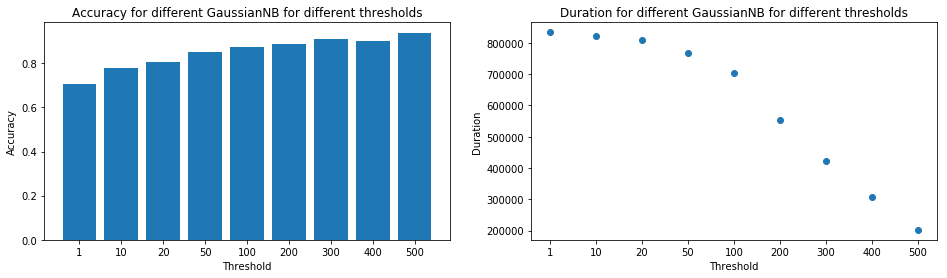

In [80]:
plot_thresh(stats, x_label='Threshold', y_labels=['Accuracy', 'Duration'], ticks=thresholds, title='for different GaussianNB for different thresholds')
plt.show()

* As we were expecting, for too small thresholds the accuracy decreases, but we don't lose too much data. As we increase the threshold, the accuracy increases as well, but we lose data. From what we can see, I would use a threshold around 100: the accuracy seems to be good enough for this simple model and from the scatter plot we can see that we lose around 10/15 % of the data.

### Random Forest

* I expect that the random forest model will fit well the data, since it uses the bagging technique: combination of learning models (decision trees in this case) increases the classification accuracy due to the fact that the combination of models creates one with low variance.

In [124]:
# Initializing and fitting the forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy')
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.87      0.88      0.88      1166
          1       0.88      0.88      0.88      1213

avg / total       0.88      0.88      0.88      2379



* As we were expecting, the result found is better than the baseline, but I want to try to increase it even more with other classifiers that are not networks.
* I'd like to compare the different thresholds also with the random forest classifier, in order to have a complete idea of the accuracy function wrt the threshold limit.

In [64]:
# Initialing the random forest
model = RandomForestClassifier(n_estimators=50, criterion='entropy')
# Getting statitics for different thresholds
stats = scikit_get_stats(data, model, thresholds)

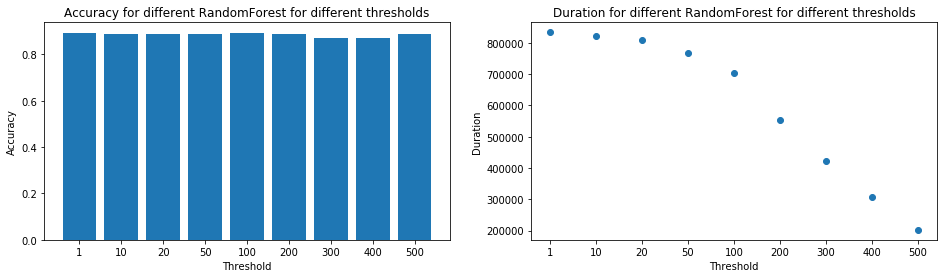

In [68]:
plot_thresh(stats, x_label='Threshold', y_labels=['Accuracy', 'Duration'], ticks=thresholds, title='for different RandomForest for different thresholds')
plt.show()

* All the accuracies for the different thresholds lay in between 85% and 90%. Apparentely the random forest classifier is not influenced by the duration of the sample. This is probably due to the fact that for every forest I am using a combination of 50 estimators and this combination is able to understand the gender even using very small samples.

### Logistic Regression - with ScikitLearn

* When we speak of binary classification, the first model that comes to my mind is the logistic regression one. It was born as the classification counter part of the linear regression, since it uses a sigmoid function as activation function. Even if the sigmoid is not a linear function, logistic regression is still a linear model since the input features are linearly combined together. The sigmoid just scale the result between 0 (very small output) and 1 (very large): if the output is larger than 0.5, we will consider it as 1, 0 otherwise.

In [127]:
# Initialing and fitting the logistic regression model
model = LogisticRegression(penalty='l2', tol=0.0001)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [128]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.83      0.83      0.83      1166
          1       0.84      0.84      0.84      1213

avg / total       0.83      0.83      0.83      2379



* The logistic regression model performs worse than the baseline, but I would like to try with the `keras` library in order to see if with a greater number of epochs it would perform better.

* As before, let's see if the Logistic Regression model has a similar behavior to the other two models using different thresholds

In [129]:
model = LogisticRegression(penalty='l2', tol=0.0001)
stats = scikit_get_stats(data, model, thresholds)

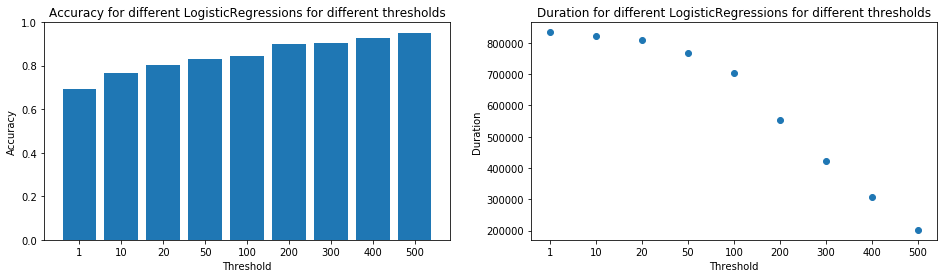

In [130]:
plot_thresh(stats, x_label='Threshold', y_labels=['Accuracy', 'Duration'], ticks=thresholds, title='for different LogisticRegressions for different thresholds')
plt.show()

* We can see that the accuracy of the logistic regression model increases in a similar fashion of the Naive Bayes Classifier, reaching more than 90% of accuracy using high thresholds.
* Higher thresholds means losing data and the incapability of classifiying shorter audio tracks: that is the reason why I am choosing 100 as threshold, that leads to discrete accuracies for the different models and not huge losses of samples. The percentiles of the lengths of the samples showed us that the 75% of the samples are longer than 162, so it will not be a big loss.

In [23]:
threshold = 100
# Subsampling the data with the given threshold
data_sub = subsample_data(data, threshold)
data_100 = data_sub
# Getting info about the subsample
print_info_subsamples(data_sub, threshold)

Threshold:  100
Number of subsamples:  7047
Sample shape:  (100, 20)
Total length:  704700


* I am switching to `keras` here. Another important reason of this change is because of the history variable that the fit method returns: I find it very useful to understands the behaviour of a model, to spot overfitting, to adjust the learning rate...

### Logistic Regression - with Keras

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.regularizers import L1L2
n_epochs = 50

def initLogisticRegression(input_dim):
    model = Sequential()
    # Adding one final node to reproduce Logistic Regression: the activation function is the sigmoid.
    # This can be seen as Ridge Regression, since I am adding a L2 regularizer to avoid overfitting and
    # generalizing the training
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=L1L2(l1=0.0, l2=0.01), input_dim=input_dim))
    return model

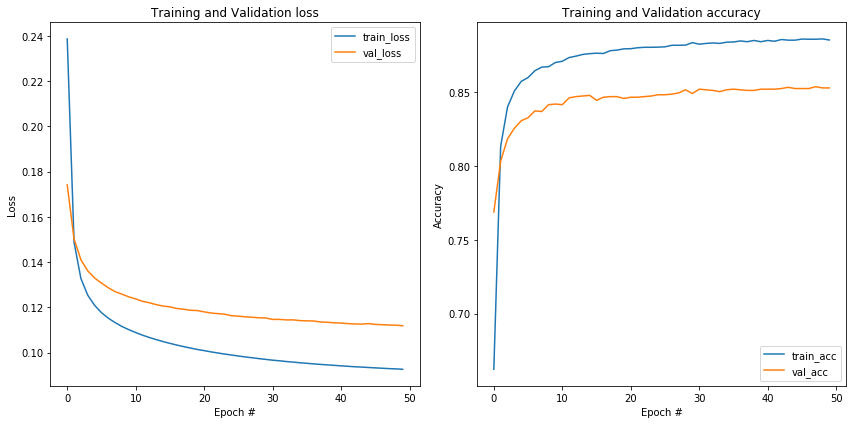

In [346]:
# Taking train and test splits
x_train, x_test, y_train, y_test = prepare_linear_data(ml_data)
# Initialing compiling and fitting the model
model = initLogisticRegression(len(x_train[0]))
model.compile(optimizer=SGD(0.01), loss='mse', metrics=['accuracy'])
H = model.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_test, y_test), batch_size=128, verbose=0)
# Plotting training and validation loss and accuracy
plot_history(H)

* Logistic regression showed us that cannot outperform the baseline, at least with this input data. Probably this happens because the input is not linearly separable, but maybe changing the input, i.e. increasing the degree of the features vector, we can avoid this problem

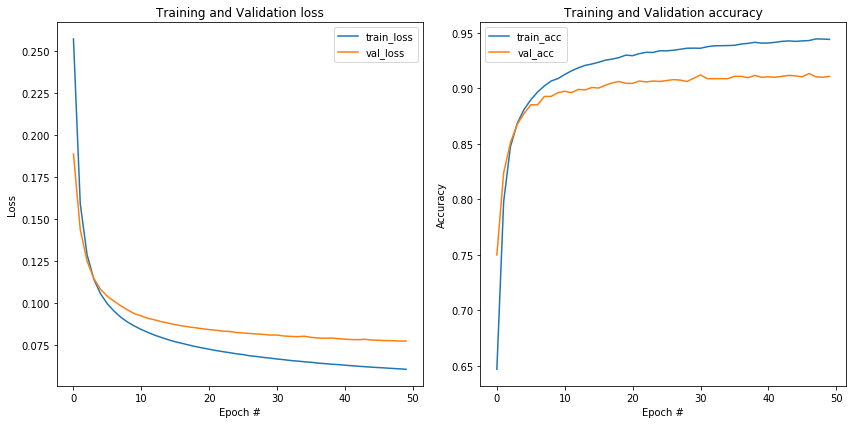

In [236]:
# Taking train and test splits, augmenting the data to a second order degree
x_train, x_test, y_train, y_test = prepare_linear_data(ml_data, degree=2)
# Initialing compiling and fitting the model
model = initLogisticRegression(len(x_train[0]))
model.compile(optimizer=SGD(0.005), loss='mse', metrics=['accuracy'])
H = model.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_test, y_test), batch_size=128, verbose=0)
# Plotting training and validation loss and accuracy
plot_history(H)

* We can see that with this small change we gained around 5% of accuracy, arriving almost at 90% and without overfitting.

### SVM

* Using the hinge loss instead of mse and tanh as activation function of the output node, we obtain a simple Support Vector Machine. I believe it is worth trying it.

*NB*: it is known that SVMs work very well with kernelized inputs. I believe that with a kernel the SVM would not perform very well since we have a very large number of inputs compared to the number of features.

In [14]:
def initSVM(input_dim):
    model = Sequential()
    model.add(Dense(1, activation='tanh', kernel_regularizer=L1L2(l1=0.0, l2=0.1), input_dim=input_dim))
    return model

In [238]:
x_train, x_test, y_train, y_test = prepare_linear_data(ml_data)
# SVMs work when the target is -1 or 1 instead of 0 and 1. So we need to modify y_train and y_test.
y_train_svm = np.array([el if el==1 else -1 for el in y_train])
y_test_svm = np.array([el if el==1 else -1 for el in y_test])

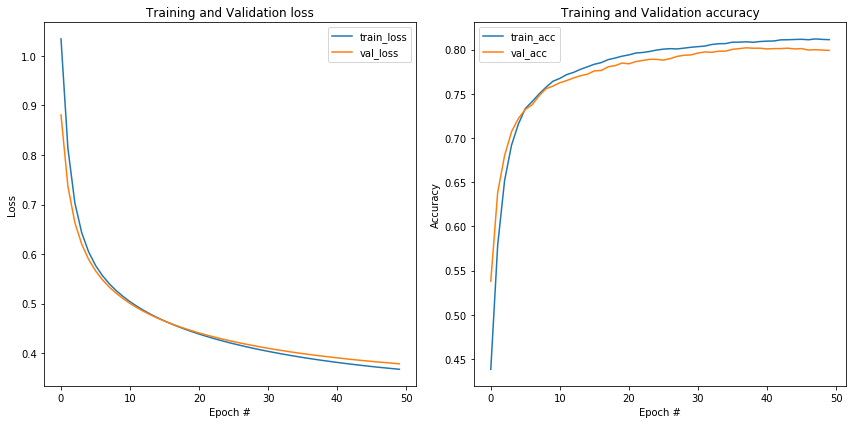

In [241]:
# Initialing, compiling and fitting the SVM
model = initSVM(len(x_train[0]))
model.compile(optimizer=SGD(0.001), loss='hinge', metrics=['accuracy'])
H = model.fit(x_train, y_train_svm, epochs=n_epochs, validation_data=(x_test, y_test_svm), batch_size=128, verbose=0)
# Plotting training and validation loss and accuracy
plot_history(H)

* SVM performs a little worse than Logistic Regression. Let's see the the performance with the augmented input.

In [231]:
# Augmenting the degree
x_train, x_test, y_train, y_test = prepare_linear_data(ml_data, 2)
# SVMs work when the target is -1 or 1 instead of 0 and 1. So we need to modify y_train and test.
y_train_svm = np.array([el if el==1 else -1 for el in y_train])
y_test_svm = np.array([el if el==1 else -1 for el in y_test])

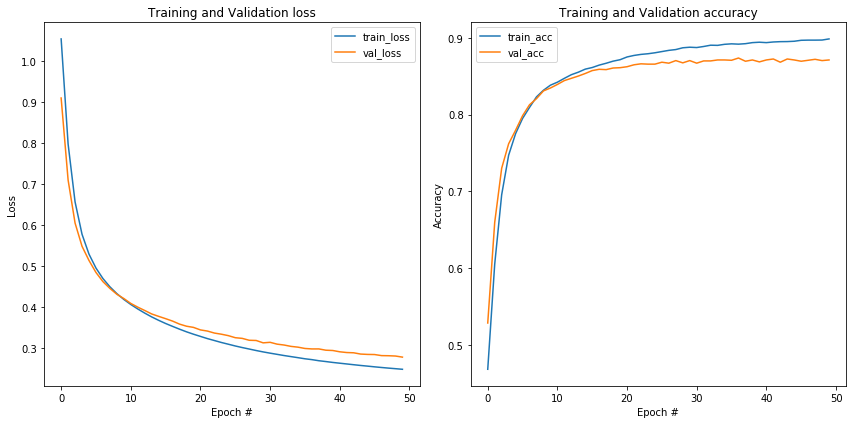

In [234]:
# Initialing, compiling and fitting the SVM
model = initSVM(len(x_train[0]))
model.compile(optimizer=SGD(0.001), loss='hinge', metrics=['accuracy'])
H = model.fit(x_train, y_train_svm, epochs=n_epochs, validation_data=(x_test, y_test_svm), batch_size=128, verbose=0)
# Plotting training and validation loss and accuracy
plot_history(H)

* SVM performs around 5% worse than Logistic Regression. Probably SVM has some difficulties because there is not enough margin to fit a m-1 hyperplane between the two classes, where m is the number of dimensions of the input vector.
* We can also observe that the validation loss was still decreasing, so probably (with the parameters used, i.e. lr=0.001 and l2=0.1) we could have reached a better result training for more time.

### Feed Forward Networks

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.regularizers import L1L2
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [16]:
def train_and_report(model, x_train, x_test, y_train, y_test, lr=0.01, n_epochs=n_epochs):
    model.compile(optimizer=SGD(lr), loss='binary_crossentropy', metrics=['accuracy'])
    H = model.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_test, y_test), batch_size=128, verbose=0)
    plot_history(H)
    return H

* Starting with a simple feedforward network with one hidden layer

In [17]:
def initOneHidden(input_dim, n_nodes):
    """
    This is the simplest NN. It contains just one hidden layer with n_nodes neurons, 
    followed by a relu and then the output layer with two final nodes with softmax activation
    to obtain the probabilities of the two classes
    """
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=input_dim))
    model.add(Dense(2, activation='softmax'))
    return model

In [275]:
# Data used for every ff_nn
x_train, x_test, y_train, y_test = prepare_nn_data(data_100)

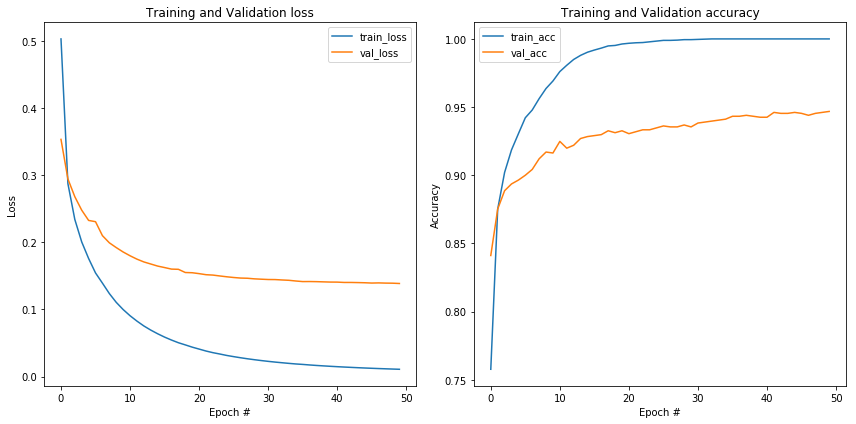

In [276]:
model = initOneHidden(input_dim=len(x_train[0]), n_nodes=100)
H = train_and_report(model, x_train, x_test, y_train, y_test)

* With a simple NN with one hidden layer we already go over 93% of accuracy
* I will build a deeper model, containing more hidden layers. In order to avoid overfitting and trying to get a lower loss I will use Batch Normalization and Dropout.

In [18]:
def initDeepNN(input_dim, n_nodes, n_layers):
    """
    This is a deeper version: it contains n_layers hidden layers, each of them
    containing n_nodes neurons. For every layer I add batch normalization 
    and dropout (20% for the input layer and 40% for remaining ones)
    """
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    for n in range(n_layers):
        model.add(Dense(n_nodes, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
    
    model.add(Dense(2, activation='softmax'))
    return model

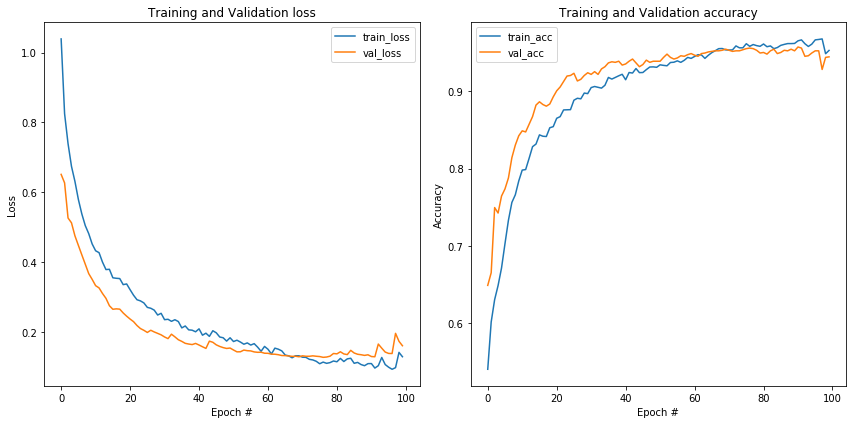

In [280]:
# Initialing the deep neural network with 4 layers each of them containing 50 neurons
model = initDeepNN(input_dim=len(x_train[0]), n_nodes=50, n_layers=4)
H = train_and_report(model, x_train, x_test, y_train, y_test, lr=0.01, n_epochs=100)

* As already stated, with deep models we have to focus more on parameters tuning: here we can see that both training and validation curves are not very smooth. Generally this indicates a learning step that is too high or a batch size that is too small.
* The performances are similar to the not deep one, even if with more epochs it would have outperformed it, since the losses were still decreasing and there were not clear signs of overfitting.

### Convolutional Networks
* Convolutional Networks are popular for image recognition tasks. But lately there have been an interest also for audio classification tasks, as we can see in [2] and in different kaggle competitions.
* Here I present two convolutional networks: a simple one (Conv => MaxPooling => FC => Output) and a more complicated one (Conv => MaxPooling => Conv => MaxPooling => FC => Output)

*[2] Shawn Hershey - [CNN Architectures for Large-Scale Audio Classification](https://arxiv.org/abs/1609.09430)*

In [19]:
def initSimpleConvNN(input_shape):
    model = Sequential()
    # Series of Conv => MaxPooling
    model.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # FC layer
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

In [20]:
def initConvNN(input_shape):
    model = Sequential()
    # First series of Conv => MaxPooling
    model.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Second series of Conv => MaxPooling
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # Fully connected layer
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

In [292]:
# Getting the right data format for a convolutional neural network
shape = data_100[:, 0][0].shape
x_train, x_test, y_train, y_test = prepare_conv_data(data_100, shape[0], shape[1])

* Let's start from the simple convolutional model:

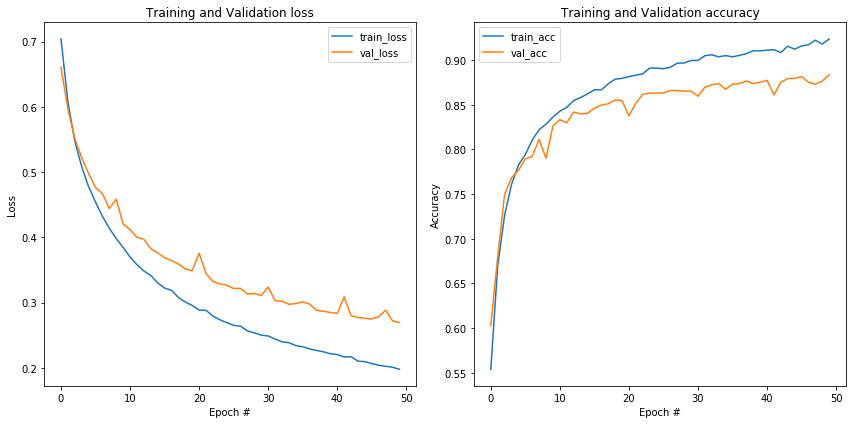

In [293]:
model = initSimpleConvNN(input_shape=x_train[0].shape)
H = train_and_report(model, x_train, x_test, y_train, y_test, lr=0.001)

* As already happened for the other deep model, the number of epochs was not enough to complete the training. Anyway, we can see that after 50 epochs the model loss was still decreasing. As before, the curves are not very smooth and the model needs more tuning.

* Now I will train the "Double" convolutional model:

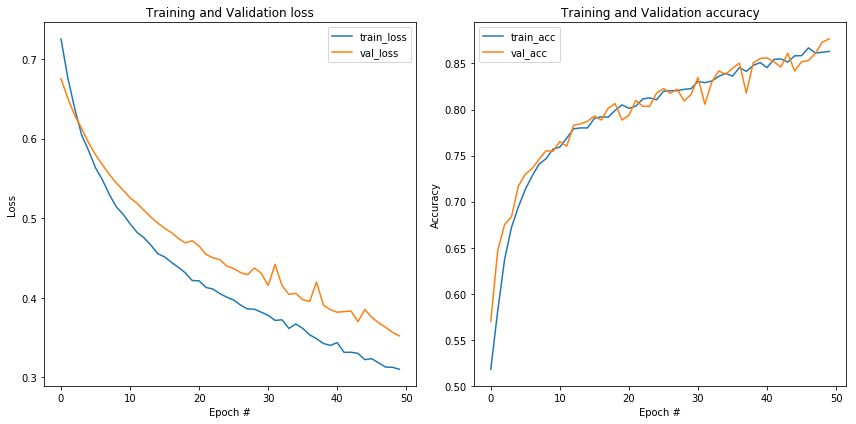

In [290]:
model = initConvNN(input_shape=x_train[0].shape)
H = train_and_report(model, x_train, x_test, y_train, y_test, lr=0.001)

* Even if at the end of epoch 50 the loss and the accuracy are respectively higher and lower than the previous model, we can see that this model will probably fit better the data. First there is less sign of overfitting than the previous one and secondly the curves's slopes are way more accentuated: this means that it will require more time to converge to a minima and consequently it will reach lower loss (and higher accuracy)

### Recurrent Neural Network
* In my opinion Recurrent Neural Networks would work for this classification task: the memory of the recurrent unit should be helpful in understanding the gender. Recurrent neural networks -- in particular LSTMs -- have been used a lot for classifications problems where the input is "time correlated". With this last expression I mean that if the input is a sequence, like a sentence, a video or, such as in this case, an audio track, RNN should fit well.
* Here, as for the convolutional section, I present two different RNNs: one simple, with one LSTM layer, and one deeper, with two LSTM layers (not bidirectional). The experience of the scientific community has shown that generally more than three/four layers of LSTMs are useless for the classification, unlike convolutional neural networks that are often built with several layers.
* I decided not to use batch normalization in order to speed up training, because with LSTMs the training can be very slow.

In [21]:
def initSimpleLSTM(input_shape):
    model = Sequential()
    # LSTM Layer
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

def initLSTM(input_shape):
    model = Sequential()
    # First LSTM Layer -- return_sequences is set to True because the second layer will need
    # the output of the first one
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    # Second LSTM Layer
    model.add(LSTM(128))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    return model

In [45]:
# Getting the right data format for a recurrent neural network
shape = data_100[:, 0][0].shape
x_train, x_test, y_train, y_test = prepare_rnn_data(data_100, shape[0], shape[1])

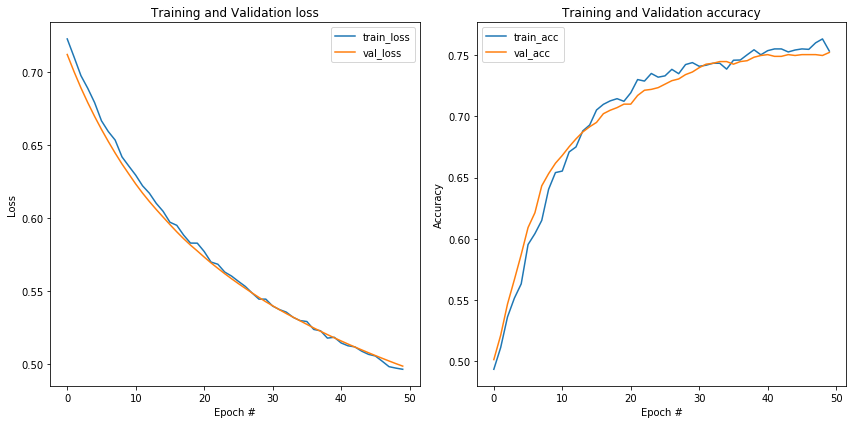

In [46]:
model = initSimpleLSTM(input_shape=x_train[0].shape)
H = train_and_report(model, x_train, x_test, y_train, y_test, lr=0.001)

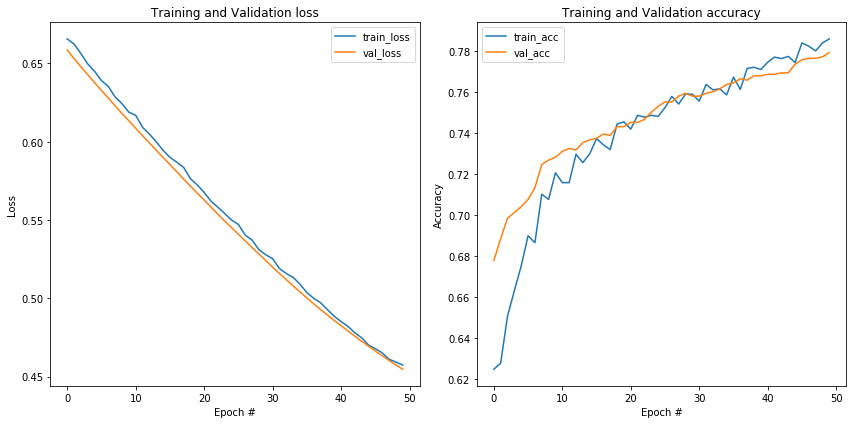

In [47]:
model = initLSTM(input_shape=x_train[0].shape)
H = train_and_report(model, x_train, x_test, y_train, y_test, lr=0.001)

* The simplest model seems not to fit well the data, even if the loss is still decreasing with a strong slope at the end of the 50th epoch.
* We can derive similar conclusions for the second one, but still the loss at the end of epoch 50 is decreasing.
* It is known that LSTM networks are very slow to train (that's why here I chose 50 epochs and the training took more time than any other previous network). I believe that with a deeper study of the model these networks could perform very well. In a future work I could add a fully connected layer between the output and the last LSTM layer and, of course, train for more epochs (200 for example).

* A peculiarity of Recurrent Neural Networks is that they can accept inputs with different lengths. Unfortunately `keras` works at a high level so it becomes complicated to reach this goal: `TensorFlow` or `Theano` (as backends) build everything as Tensors or matrices of matrices and that implies same dimensionality for every input. Using `TensorFlow` or `PyTorch` instead of `keras` would let us avoid the problem of subsampling the inputs and use them as they were given.
* We could also try more complicated models, such as a Recurrent Neural Network with convolutional input and recurrent transformations, but I would like to pause for the moment and compare what we have until now and derive some observations.

### Comparison of different models

##### Getting the right data format for the different architectures

In [24]:
# Linear data
x_train_lin, x_test_lin, y_train_lin, y_test_lin = prepare_linear_data(data_100, degree=2)
y_train_svm = np.array([el if el==1 else -1 for el in y_train_lin])
y_test_svm = np.array([el if el==1 else -1 for el in y_test_lin])

# Feed forward
x_train_ff, x_test_ff, y_train_ff, y_test_ff = prepare_nn_data(data_100)

# Convolution
shape = data_100[:, 0][0].shape
x_train_conv, x_test_conv, y_train_conv, y_test_conv = prepare_conv_data(data_100, shape[0], shape[1])

# Recurrent
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = prepare_rnn_data(data_100, shape[0], shape[1])

* Since the different architectures need different learning rates, different losses and different data formats, I am collecting everything before the actual comparison. The variable `args` is a dictionary containing as keys the name of the models and as values the dictionaries containing the right parameters for every model. In this way I can call the function `train_model` in a for loop without worrying about the data to pass as parameter of the function

In [48]:
# Parameters for the feed forward networks
ff_dict = {'lr': 0.01, 'loss': 'binary_crossentropy', 'data': (x_train_ff, x_test_ff, y_train_ff, y_test_ff)}
# Parameters for the convolutional neural networks
conv_dict = {'lr': 0.001, 'loss': 'binary_crossentropy', 'data': (x_train_conv, x_test_conv, y_train_conv, y_test_conv)}
# Parameters for the recurrent neural networks
rnn_dict = {'lr': 0.001, 'loss': 'binary_crossentropy', 'data': (x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn)}

# model - parameters dictionary
args = {'logreg': {'lr': 0.01, 'loss': 'mse', 'data': (x_train_lin, x_test_lin, y_train_lin, y_test_lin)},
        'svm': {'lr': 0.01, 'loss': 'hinge', 'data': (x_train_lin, x_test_lin, y_train_svm, y_test_svm)},
        'onehidden': ff_dict, 'deepnn': ff_dict,
        'simpleconv': conv_dict, 'deepconv': conv_dict,
        'simplelstm': rnn_dict, 'deeplstm': rnn_dict
       }

##### Comparison
* In order to compare the results of the model in a coherent way, I am going to train every model for `n_rounds`, that I have chosen to be 20. Even if it requires long time, I believe that this is one of the best way when it comes to compare different models: we can better generalize the behavior of the model with a few more statistical data. I know that 20 is not much, but it requires a long time to train 8 models for 20 times (each time for 100 epochs), specially when there are two recurrent neural networks with LSTM units.
* For every round I am saving the `early stopping` loss and the corresponding accuracy. I am not using any keras callback for the early stopping - that means stopping the training when the controlled metric, such as the loss, does not improve for a certain number of epochs (aka patience). Instead, I am training every model for 100 epochs and taking the smallest loss happened during the training. As we have seen in the previous training, the models were not showing clear signs of overfitting, so I believe that every model can continue to train for the 100 epochs without losing generality.

In [38]:
def train_model(model_name, parameters):
    """
    Given the model name and its corresponding parameter, the function
    initialize the correct model, compile it and fit it for 100 epochs.
    Then it returns the lowest loss and the corresponding accuracy
    """
    lr = parameters['lr']
    loss = parameters['loss']
    x_train, x_test, y_train, y_test = parameters['data']
    
    # Switching on models
    if model_name == 'logreg':
        model = initLogisticRegression(len(x_train[0]))
    elif model_name == 'svm':
        model = initSVM(len(x_train[0]))
    elif model_name == 'onehidden':
        model = initOneHidden(input_dim=len(x_train[0]), n_nodes=100)
    elif model_name == 'deepnn':
        model = initDeepNN(input_dim=len(x_train[0]), n_nodes=50, n_layers=4)
    elif model_name == 'simpleconv':
        model = initSimpleConvNN(input_shape=x_train[0].shape)
    elif model_name == 'deepconv':
        model = initConvNN(input_shape=x_train[0].shape)
    elif model_name == 'simplelstm':
        model = initSimpleLSTM(input_shape=x_train[0].shape)
    elif model_name == 'deeplstm':
        model = initLSTM(input_shape=x_train[0].shape)
    
    model.compile(optimizer=SGD(lr), loss=loss, metrics=['accuracy'])
    H = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=128, verbose=0)
    # Early stopping
    index = np.argmin(H.history['val_loss'])
    return H.history['val_loss'][index], H.history['val_acc'][index]

In [40]:
# Statitics of the different models. It will be updated every round
stats = {'logreg_loss':[], 'logreg_acc':[],
         'svm_loss': [], 'svm_acc': [],
         'onehidden_loss': [], 'onehidden_acc': [],
         'deepnn_loss': [], 'deepnn_acc': [],
         'simpleconv_loss': [], 'simpleconv_acc': [],
         'deepconv_loss': [], 'deepconv_acc': [],
         'simplelstm_loss': [], 'simplelstm_acc': [],
         'deeplstm_loss': [], 'deeplstm_acc': []
       }

In [41]:
n_rounds = 20
# Training the every model n_rounds times
for i in range(n_rounds):
    if (i+1) % 5 == 0 or i==0:
        print('[INFO] Round number {} out of {}'.format(i+1, n_rounds))
    for key, value in args.items():
        val_loss, val_acc = train_model(key, value)
        # Updating the statitics about loss and accuracy for every model
        stats[key + '_loss'].append(val_loss)
        stats[key + '_acc'].append(val_acc)

[INFO] Round number 1 out of 20
[INFO] Round number 5 out of 20
[INFO] Round number 10 out of 20
[INFO] Round number 15 out of 20
[INFO] Round number 20 out of 20


In [42]:
stats_df = pd.DataFrame(stats, columns=stats.keys())
stats_df.to_csv('stats_df.csv')

* After the trainings, I saved the statitics to file. Now I am going to plot as boxplots the various information collected in order to derive some more observation than before.

In [54]:
stats_df = pd.read_csv('stats_df.csv').drop('Unnamed: 0', axis=1)
stats_df.head()

,logreg_loss,logreg_acc,svm_loss,svm_acc,onehidden_loss,onehidden_acc,deepnn_loss,deepnn_acc,simpleconv_loss,simpleconv_acc,deepconv_loss,deepconv_acc,simplelstm_loss,simplelstm_acc,deeplstm_loss,deeplstm_acc
0,0.064419,0.932624,0.216927,0.902128,0.138274,0.947518,0.126855,0.952482,0.194506,0.912057,0.164808,0.930496,0.406429,0.808511,0.376871,0.836879
1,0.064815,0.928369,0.217537,0.903546,0.121390,0.951773,0.136398,0.953191,0.200297,0.917730,0.168992,0.924823,0.415007,0.807801,0.292693,0.875887
2,0.065394,0.926950,0.217984,0.903546,0.141675,0.947518,0.119429,0.953901,0.226213,0.911348,0.136892,0.948227,0.439841,0.787943,0.257858,0.900709
3,0.063181,0.929787,0.216549,0.905674,0.125617,0.949645,0.129627,0.949645,0.190980,0.923404,0.239430,0.895035,0.430365,0.804965,0.334335,0.854610
4,0.065037,0.929787,0.217988,0.901418,0.129112,0.960284,0.137054,0.951773,0.206009,0.912057,0.147409,0.936879,0.369651,0.835461,0.324199,0.856738


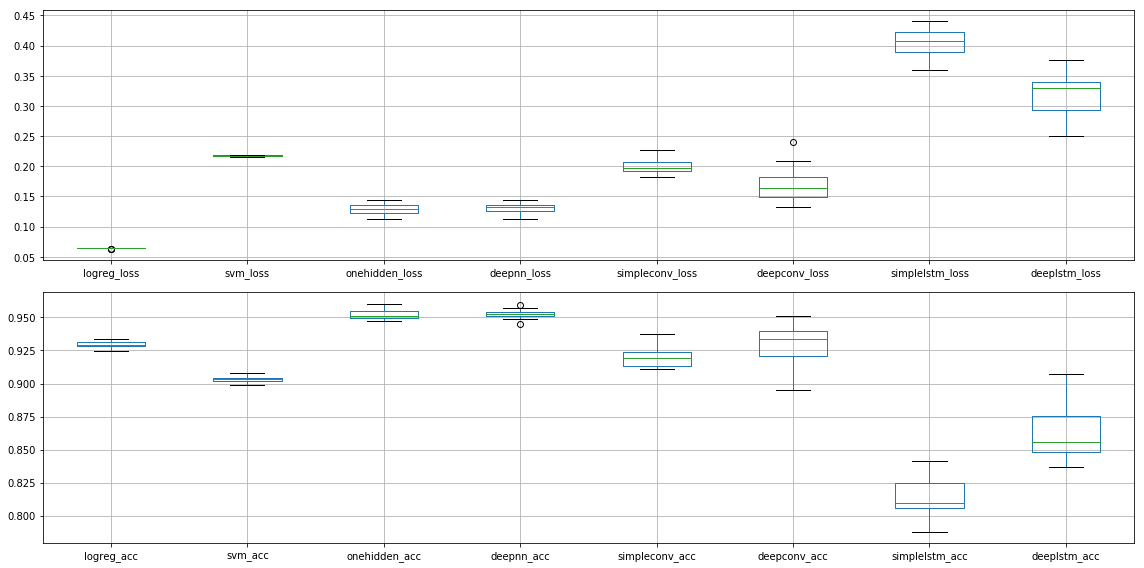

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))
stats_df.filter(regex='.*_loss').boxplot(ax=axes[0])
stats_df.filter(regex='.*_acc').boxplot(ax=axes[1])
plt.tight_layout()
plt.show()

* **Logistic Regression**: The results are a little surprising. If we use as evaluation metric the loss of the models, the simplest one, that is the Logistic Regression, is the one with the smallest loss compared to all the others. But the reason is not only because it is a good model: for the Logistic Regression I have used MSE as error function, while for the other models, with the exception of the SVM, I have used the binary cross entropy loss function. So we should compare Logistic Regression with the other models taking account the accuracy: it is comparable to the deep convolutional network (around 93%). We can also observe that the model is very strong: by that, I mean that the variance of the results is not high and all the results are concentrated around 92%/93% of accuracy. This is an example how, even simple models, can perform very well in a small time. With data augmentation techniques and more parameters tuning I am sure that this model could have reached even better results.

* **Fully Connected Networks**: I was hoping that with 100 epochs CNNs would have had performed better that the fully connected ones, but this was not the case. Even with these results, we can't be sure about the performance of every model. We can say that the two feed forward fully connected networks probably reached the maximum result they could (very small variance, no outliers for the first one and very close outliers for the second one), but we cannot derive the same conclusions for CNNs and LSTMs. We can say with certainty that the two fully connected networks are the best models with a 100 as fixed number of epochs, but we don't know if this reflects the reality (actually, I doubt it). In order to work, I have had to flatten the inputs, losing the information of time. This information is still present in CNNs and LSTMs. Another point I would like to highlight is that we can see that there is not a serious need of building a very deep FC network, since the gain in loss and accuracy is very small. Probably we could get better results using a FC network with 2/3 layers but more neurons (the number of features for a subsample is 20x100 and in the deep network I use only 50 neurons per layer).

* **CNNs**: I was a little disappointed by the results of CNNs. The literature on audio classification demonstrates that the experiments are going towards this direction, so I was hoping to reproduce them. It is true that the deepConv is not very deep compared to AlexNet or VGGNet, but still it couldn't outperform Logistic Regression. With the knowledge of time hidden somewhere in the kernels of the convolution, I was expecting that the convolution would have understood the audio tracks in a better way. Probably with more filters and more layers the CNN will have outperformed the FC networks.

* **LSTMs**: In contrast to what I said about Convolutional Neural Networks, the results of LSTMs are not that surprising. I was expecting something better, but the big variance of the results indicate that probably the models were not converged when the training finished. In order to train every model for 20 times, I had to compromise on something and LSTM networks are the ones that suffered more: no fully connected layers before the output layer and no batch normalization. I believe that these things would have made the difference (especially the FC layer), but on the other hand it would have required a lot of time. As we have seen in the first experiments with the recurrent neural networks and 50 epochs, the loss was still decreasing at the end of the last one and I believe that this is still the case for 100 epochs. LSTM units (or GRU) are known for their power of maintaining the knowledge of what they have seen in the past (and in the bidirectional version also in the future) and I believe that this could be a right lead to follow for this task.

* **General Observations**: Looking at this plot it is clear that very complicated models are not necessary in order to get a good results and probably a good way to procede is to manipulate the data in smart ways in order to improve the simple models. Another point I would like to make is that the losses and the accuracies we can see are what I called the early stopping losses/accuracies, because I was taking the minimum loss and the corresponding accuracy throughout all the 100 epochs. This shouldn't be a problem, but for some models, for example the CNNs and RNNs, where the learning curves are not smooth at all, maybe the loss taken was just a "lucky" one: if there was a spike going down in the middle of the training, that would have been the loss considered. If I was smoothing the curve, that loss would have been higher.

## Conclusions

* In this notebook we have studied the behaviours of different models for a gender classification task given audio data. It has been fun and in certain points even surprising. I believe that what I have done here is only the tip of the iceberg of what one can do about this classification problem. There are a lot of other techniques that have not been considered but that I believe is worth mentioning. We have seen only the shadow of bagging when I trained the random forest model, but it is a common technique to train the same model different times and take the average of the results as final output (similar to the final observations in the boxplot). Another similar technique is the stacked ensemble model, that is putting together the different (good) models trained and taking the combined output. I didn't focus a lot on parameter tuning, such as the tuning of the learning rate, the number of nodes of the FC networks, the number of filters of the CNNs, the size of the hidden unit of the RNNs, the probability of the Dropout and the other parameters. In a more depth study, this are very important things to consider in order to get improved loss and accuracy. With a different library, as already said, I could have shown that Recurrent Neural Network can avoid the problem of a fixed size, that is a big improvment for the problem.